# USAD

## Environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Anormaly/USAD

/content/drive/MyDrive/Anormaly/USAD


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import pickle
from utils import *
from usad import *
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score, confusion_matrix
from scipy.optimize import brentq
from scipy.interpolate import interp1d

## EDA - Data Pre-Processing

In [4]:
down_rate = 1

### Download dataset

### Normal period

In [5]:
# Read data
normal = pd.read_csv("data/SWaT_normal_data_v0.csv")
normal = normal.drop(["Timestamp", "Normal/Attack", "AIT201", "AIT202", "AIT203", "P201", "AIT401", "AIT402", "AIT501",  "AIT502", "AIT503", "AIT504", "FIT503", "FIT504", "PIT501", "PIT502", "PIT503"], axis=1)
normal.shape

(496800, 36)

In [6]:
# Transform all columns into float64
for i in list(normal):
    normal[i] = normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)

In [7]:
# Downsampling
normal = normal.groupby(np.arange(len(normal.index)) // down_rate).mean()
normal.shape

(496800, 36)

#### Normalization

In [8]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
filename = 'min_max_scaler.sav'
pickle.dump(min_max_scaler, open(filename, 'wb'))
normal = pd.DataFrame(x_scaled)

In [9]:
normal.head(35)

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.899895,0.160292,1.0,1.0,0.0,0.993304,1.0,0.0,1.0,0.0,...,0.0,0.0,0.000511,0.000565,0.0,0.0,0.000147,0.0,0.0,0.0
1,0.895111,0.159845,1.0,1.0,0.0,0.992222,1.0,0.0,1.0,0.0,...,0.0,0.0,0.000511,0.000565,0.0,0.0,0.000147,0.0,0.0,0.0
2,0.888694,0.159533,1.0,1.0,0.0,0.991707,1.0,0.0,1.0,0.0,...,0.0,0.0,0.000511,0.000565,0.0,0.0,0.000147,0.0,0.0,0.0
3,0.884611,0.158819,1.0,1.0,0.0,0.991398,1.0,0.0,1.0,0.0,...,0.0,0.0,0.000511,0.000565,0.0,0.0,0.000147,0.0,0.0,0.0
4,0.883327,0.158372,1.0,1.0,0.0,0.991398,1.0,0.0,1.0,0.0,...,0.0,0.0,0.000511,0.000565,0.0,0.0,0.000147,0.0,0.0,0.0
5,0.883561,0.158551,1.0,1.0,0.0,0.990831,1.0,0.0,1.0,0.0,...,0.0,0.0,0.000511,0.000565,0.0,0.0,0.000147,0.0,0.0,0.0
6,0.900828,0.158729,1.0,1.0,0.0,0.990677,1.0,0.0,1.0,0.0,...,0.0,0.0,0.000511,0.000565,0.0,0.0,0.000147,0.0,0.0,0.0
7,0.915646,0.159176,1.0,1.0,0.0,0.992119,1.0,0.0,1.0,0.0,...,0.0,0.0,0.000511,0.000565,0.0,0.0,0.000147,0.0,0.0,0.0
8,0.932563,0.159667,1.0,1.0,0.0,0.992634,1.0,0.0,1.0,0.0,...,0.0,0.0,0.000511,0.000565,0.0,0.0,0.000147,0.0,0.0,0.0
9,0.946447,0.159756,1.0,1.0,0.0,0.993149,1.0,0.0,1.0,0.0,...,0.0,0.0,0.000511,0.000565,0.0,0.0,0.000147,0.0,0.0,0.0


### Attack

In [10]:
# Read data
attack = pd.read_csv("data/SWaT_attack_data_v0.csv")
labels = [float(label!='Normal') for label in attack["Normal/Attack"].values]
attack = attack.drop(["Timestamp" , "Normal/Attack", "AIT201", "AIT202", "AIT203", "P201", "AIT401", "AIT402", "AIT501", "AIT502", "AIT503", "AIT504", "FIT503", "FIT504", "PIT501", "PIT502", "PIT503"], axis=1)
attack.shape

(449919, 36)

In [11]:
# Transform all columns into float64
for i in list(attack):
    attack[i] = attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)

In [12]:
# Downsampling the attack data
attack = attack.groupby(np.arange(len(attack.index)) // down_rate).mean()
attack.shape

(449919, 36)

In [13]:
# Downsampling the labels
labels_down=[]

if down_rate == 1:
    labels_down = labels
else:
    for i in range(len(labels) // down_rate):
        if labels[down_rate*i:down_rate*(i+1)].count(1.0):
            labels_down.append(1.0) # Attack
        else:
            labels_down.append(0.0) # Normal

    # for the last few labels that are not within a full-length window
    if labels[down_rate*(i+1):].count(1.0):
        labels_down.append(1.0) # Attack
    else:
        labels_down.append(0.0) # Normal

print(len(labels_down))

449919


#### Normalization

In [14]:
from sklearn import preprocessing
x = attack.values
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

In [15]:
attack.head(2)

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.884144,0.457396,1.0,1.0,0.0,0.982899,1.0,0.0,1.0,0.0,...,0.0,1.0,0.980669,0.939499,1.0,0.0,0.000073,0.0,0.0,0.0
1,0.891145,0.457440,1.0,1.0,0.0,0.982899,1.0,0.0,1.0,0.0,...,0.0,1.0,0.980669,0.952672,1.0,0.0,0.000073,0.0,0.0,0.0


### Windows

In [16]:
window_size = 30

In [17]:
windows_normal = normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0] - window_size)[:, None]]
windows_normal.shape

(496770, 30, 36)

In [18]:
windows_normal[1]

array([[0.89511135, 0.15984534, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.88869444, 0.15953284, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.88461079, 0.15881859, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.88426071, 0.16033625, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.88356092, 0.16051479, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.88356092, 0.16020241, 1.        , ..., 0.        , 0.        ,
        0.        ]])

In [19]:
windows_attack = attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0] - window_size)[:, None]]
windows_attack.shape

(449889, 30, 36)

## Training

In [20]:
BATCH_SIZE = 7919
N_EPOCHS = 1
hidden_size = 64

In [21]:
import torch.utils.data as data_utils

w_size = windows_attack.shape[1]*windows_attack.shape[2]
z_size = windows_attack.shape[1]*hidden_size

# windows_normal_train = windows_normal[:int(np.floor(.8 * windows_normal.shape[0]))]
# windows_normal_val = windows_normal[int(np.floor(.8 * windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

# train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
#     torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0], w_size]))
# ), batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
#     torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0], w_size]))
# ), batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0], w_size]))
), batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model, device)

In [22]:
# history = training(N_EPOCHS, model, train_loader, val_loader)

In [23]:
# torch.save({'encoder': model.encoder.state_dict(),
#             'decoder1': model.decoder1.state_dict(),
#             'decoder2': model.decoder2.state_dict()}, "model_SWaT.pth")

## Testing

In [24]:
filename = 'min_max_scaler.sav'
min_max_scaler = pickle.load(open(filename, 'rb'))

In [25]:
checkpoint = torch.load("model_SWaT.pth", map_location=torch.device('cpu'))
model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [26]:
with torch.no_grad():
    results = training_scores(model, test_loader) # testing

In [27]:
len(results)

57

In [28]:
results

[tensor([0.0003, 0.0003, 0.0003,  ..., 0.0045, 0.0045, 0.0045], device='cuda:0'),
 tensor([0.0044, 0.0044, 0.0044,  ..., 0.0894, 0.0894, 0.0894], device='cuda:0'),
 tensor([0.0894, 0.0894, 0.0894,  ..., 0.0005, 0.0005, 0.0005], device='cuda:0'),
 tensor([0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0005, 0.0005], device='cuda:0'),
 tensor([0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0006, 0.0006], device='cuda:0'),
 tensor([0.0006, 0.0006, 0.0006,  ..., 0.0248, 0.0259, 0.0270], device='cuda:0'),
 tensor([0.0279, 0.0287, 0.0292,  ..., 0.0127, 0.0125, 0.0120], device='cuda:0'),
 tensor([0.0114, 0.0106, 0.0099,  ..., 0.0011, 0.0011, 0.0011], device='cuda:0'),
 tensor([0.0011, 0.0011, 0.0011,  ..., 0.0004, 0.0004, 0.0004], device='cuda:0'),
 tensor([0.0004, 0.0004, 0.0004,  ..., 0.0005, 0.0005, 0.0005], device='cuda:0'),
 tensor([0.0005, 0.0005, 0.0005,  ..., 0.0003, 0.0003, 0.0003], device='cuda:0'),
 tensor([0.0003, 0.0003, 0.0003,  ..., 0.0003, 0.0003, 0.0003], device='cuda:0'),
 tensor([0.0003,

In [29]:
windows_labels = []
for i in range(len(labels_down) - window_size):
    windows_labels.append(list(np.int_(labels_down[i:i+window_size])))

In [30]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels] # this is with the point adjust?

In [31]:
len(y_test)

449889

In [32]:
y_pred = np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(), results[-1].flatten().detach().cpu().numpy()])

In [33]:
y_pred.shape

(449889,)

In [34]:
with torch.no_grad():
    results_threshold = testing_threshold(model, test_loader, contamination=0.11)

In [35]:
results_threshold

0.02899056

In [36]:
threshold = results_threshold # Decide on your own threshold
y_pred_label = [1.0 if (score > threshold) else 0 for score in y_pred]

In [37]:
precision = precision_score(y_test, y_pred_label, pos_label=1)
recall = recall_score(y_test, y_pred_label, pos_label=1)
f1 = f1_score(y_test, y_pred_label, pos_label=1)
auc = roc_auc_score(y_test,y_pred)
fpr, tpr, threshold = roc_curve(y_test, y_pred, pos_label=1)
fnr = 1 - tpr
eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print('precision =', precision)
print('recall =', recall)
print('f1 =', f1)
print('AUC =', auc)
print('EER =', eer)

precision = 0.8007961686907673
recall = 0.7122906032065569
f1 = 0.7539548909372831
AUC = 0.9052527260410351
EER = 0.1541345278285771


In [38]:
def calculate_tpr_fpr(cm):
    TP = cm[1][1]
    FN = cm[1][0]
    FP = cm[0][1]
    TN = cm[0][0]
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    return TPR, FPR

In [39]:
cm = confusion_matrix(y_test, y_pred_label)

In [40]:
tpr, fpr = calculate_tpr_fpr(cm)

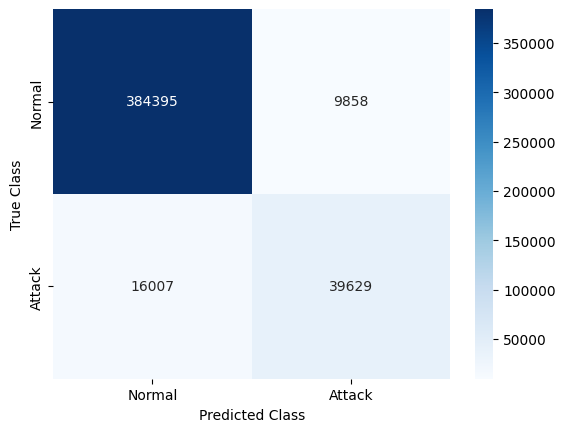

In [41]:
from sklearn.metrics import confusion_matrix
LABELS = [0 , 1]
cm = confusion_matrix(y_test, y_pred_label, labels=LABELS)
fig, ax = plt.subplots()
_ = sns.heatmap(cm ,xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'],
               annot=True,cmap="Blues",fmt = "d",ax=ax)
_ = ax.set_xlabel('Predicted Class')
_ = ax.set_ylabel('True Class')

In [42]:
def plot_roc_curve(fpr, tpr, auc):
    fpr_values, tpr_values = [0, fpr, 1], [0, tpr, 1]
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.plot(fpr_values, tpr_values, label="AUC="+str(auc))
    plt.title('USAD ROC Curve')
    plt.legend()
    plt.show()

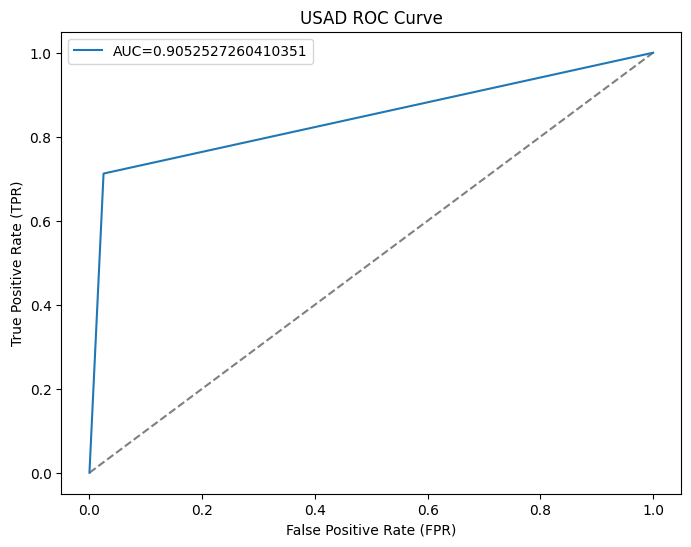

In [43]:
plot_roc_curve(fpr, tpr, auc)